In [1]:
import re
import nltk
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Activation,Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten,GlobalMaxPooling1D,Conv1D, Embedding, LSTM

In [2]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


>Checking for null values:

In [4]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

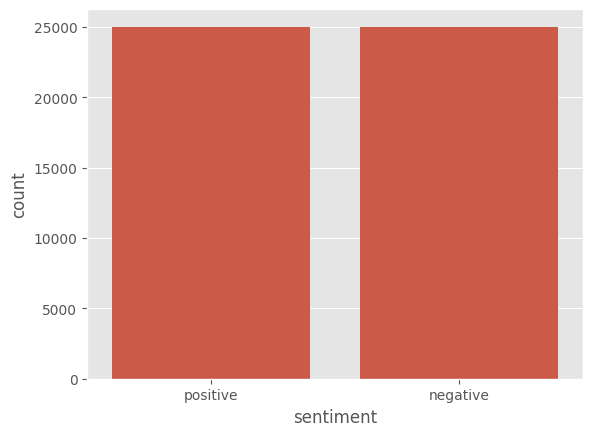

In [5]:
import seaborn as sns
plt.style.use("ggplot")
sns.countplot(data = df, x = df["sentiment"])
plt.show()

In [6]:
df["sentiment"].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

- So, there is no class imbalance both class has an equal number of data.

In [7]:
df["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [8]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words('english'))

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)
    

class CustomPreprocess():

    def __init__(self):
        pass

    def preprocess_text(self,sen):
        sen = sen.lower()
        
        # Remove html tags
        sentence = remove_tags(sen)

        # Remove punctuations and numbers
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        
        # Single character removal
        sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

        # Remove multiple spaces
        sentence = re.sub(r'\s+', ' ', sentence)
        
        # Remove Stopwords
        pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
        sentence = pattern.sub('', sentence)
        
        return sentence

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
custom = CustomPreprocess()
custom.preprocess_text("I thought this was a wonderful way to spend time on a too hot summer weekend")

'thought wonderful way spend time hot summer weekend'

In [10]:
x = []
sentences = list(df['review'])
for sen in sentences:
    x.append(custom.preprocess_text(sen))

In [11]:
y = df['sentiment']
sentiment_map = {'negative' : 0, 'positive': 1}
y = np.array(y.map(sentiment_map))
y[:15]

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int64)

In [12]:
x_train, x_test, y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

> Creating Embedding Layer:

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [14]:
import io
import json
tokenizer_json = tokenizer.to_json()

with io.open("tokenizer.json", 'w', encoding = "utf-8") as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii = False))

In [15]:
vocab_length = len(tokenizer.word_index)+1
vocab_length

92394

In [16]:
maxlen = 100

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [17]:
embedding_dict = dict()
glove_file = open("glove.6B.100d.txt", encoding = 'utf8')
embeddings_dictionary = dict()
for line in glove_file:
    records = line.split()
    words = records[0]
    vector_dimensions = np.asarray(records[1:], dtype = 'float32')
    embeddings_dictionary[words] = vector_dimensions
glove_file.close()

In [18]:
print(list(tokenizer.word_index.items())[:15])

[('movie', 1), ('film', 2), ('one', 3), ('like', 4), ('good', 5), ('time', 6), ('even', 7), ('would', 8), ('story', 9), ('really', 10), ('see', 11), ('well', 12), ('much', 13), ('bad', 14), ('get', 15)]


In [19]:
embeddings_dictionary.get('film')

array([ 0.19916 , -0.049702,  0.24579 , -0.32281 ,  0.89768 , -0.1278  ,
       -0.49506 ,  0.20814 , -0.20046 , -0.20604 ,  0.038292, -0.67277 ,
       -0.12689 , -0.18766 , -0.10277 ,  0.73128 ,  0.82408 ,  0.087288,
        0.69255 ,  1.3107  ,  0.49113 , -0.38097 ,  0.24338 , -0.27813 ,
        0.62506 ,  0.35978 ,  0.42041 , -0.24529 ,  0.14861 , -0.26726 ,
       -0.56262 ,  0.63843 , -0.54153 ,  0.36537 ,  0.20545 , -0.16604 ,
        0.72434 ,  0.29961 , -0.42501 , -0.35932 , -0.089288,  0.48752 ,
       -1.0927  ,  0.88818 ,  0.89941 , -0.7541  , -0.35492 , -0.76396 ,
        0.27468 ,  0.2757  , -0.48152 , -0.41399 ,  0.64489 ,  1.148   ,
       -0.29131 , -2.9387  , -0.83162 ,  0.95586 ,  1.1623  , -0.42502 ,
        0.15486 ,  2.2326  , -0.31339 , -0.030228,  0.79802 , -0.41302 ,
        0.72885 ,  0.7296  , -0.31909 ,  0.8956  ,  0.34625 ,  0.2923  ,
        0.40056 ,  0.78985 , -0.43999 ,  0.24698 , -0.46548 ,  0.055886,
       -0.62603 , -0.036487, -0.65429 ,  0.10563 , 

In [20]:
embeddings_dictionary['film']

array([ 0.19916 , -0.049702,  0.24579 , -0.32281 ,  0.89768 , -0.1278  ,
       -0.49506 ,  0.20814 , -0.20046 , -0.20604 ,  0.038292, -0.67277 ,
       -0.12689 , -0.18766 , -0.10277 ,  0.73128 ,  0.82408 ,  0.087288,
        0.69255 ,  1.3107  ,  0.49113 , -0.38097 ,  0.24338 , -0.27813 ,
        0.62506 ,  0.35978 ,  0.42041 , -0.24529 ,  0.14861 , -0.26726 ,
       -0.56262 ,  0.63843 , -0.54153 ,  0.36537 ,  0.20545 , -0.16604 ,
        0.72434 ,  0.29961 , -0.42501 , -0.35932 , -0.089288,  0.48752 ,
       -1.0927  ,  0.88818 ,  0.89941 , -0.7541  , -0.35492 , -0.76396 ,
        0.27468 ,  0.2757  , -0.48152 , -0.41399 ,  0.64489 ,  1.148   ,
       -0.29131 , -2.9387  , -0.83162 ,  0.95586 ,  1.1623  , -0.42502 ,
        0.15486 ,  2.2326  , -0.31339 , -0.030228,  0.79802 , -0.41302 ,
        0.72885 ,  0.7296  , -0.31909 ,  0.8956  ,  0.34625 ,  0.2923  ,
        0.40056 ,  0.78985 , -0.43999 ,  0.24698 , -0.46548 ,  0.055886,
       -0.62603 , -0.036487, -0.65429 ,  0.10563 , 

In [21]:
embedding_matrix = np.zeros((vocab_length, 100)) #100
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [22]:
embedding_matrix.shape

(92394, 100)

> Model Building:
>> Simple Neural Network:

In [23]:
snn = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
snn.add(embedding_layer)
snn.add(Flatten())
snn.add(Dense(16, activation='relu'))
snn.add(Dense(1,activation = 'sigmoid'))

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
snn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
snn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

In [25]:
history_snn = snn.fit(x_train,y_train, batch_size=128, epochs = 10, 
                      verbose=1, validation_split =0.2)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.6785 - loss: 0.5946 - val_accuracy: 0.7674 - val_loss: 0.4900
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.8114 - loss: 0.4208 - val_accuracy: 0.7694 - val_loss: 0.4853
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.8437 - loss: 0.3588 - val_accuracy: 0.7596 - val_loss: 0.5145
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.8704 - loss: 0.3149 - val_accuracy: 0.7433 - val_loss: 0.5593
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.8867 - loss: 0.2781 - val_accuracy: 0.7384 - val_loss: 0.5854
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9027 - loss: 0.2449 - val_accuracy: 0.7498 - val_loss: 0.5922
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9200 - loss: 0.2105 - val_accuracy: 0.7458 - val_loss: 0.6430
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.9394 - loss: 0.1763 - 

In [26]:
result = snn.evaluate(x_test,y_test, verbose = 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7175 - loss: 0.8748


In [27]:
print("Test Accuracy:", result[1])
print("Test Loss:", result[0])

Test Accuracy: 0.7221999764442444
Test Loss: 0.8679770231246948


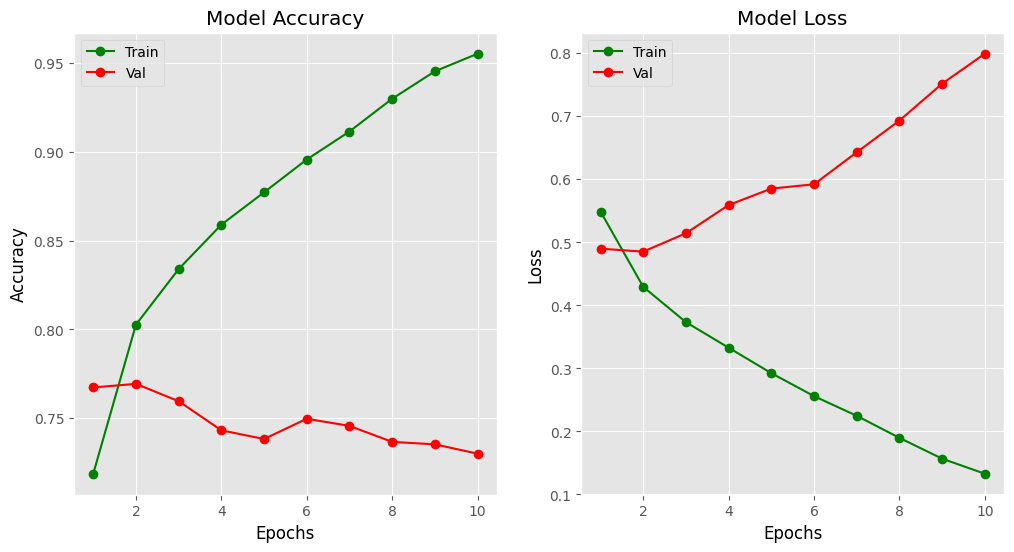

In [28]:
plt.figure(figsize=(12,6))
epochs = range(1,11)
plt.subplot(1,2,1)
plt.plot(epochs,history_snn.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_snn.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_snn.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_snn.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

> Convolutional Neural Network:

In [29]:
from keras.layers import Conv1D
cnn = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
cnn.add(embedding_layer)
cnn.add(Conv1D(128,5,activation = 'relu'))
cnn.add(Dropout(0.2))

cnn.add(Conv1D(256,5,activation = 'relu'))
cnn.add(GlobalMaxPooling1D())

cnn.add(Dense(1,activation = 'sigmoid'))

In [30]:
cnn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

In [31]:
history_cnn = cnn.fit(x_train,y_train, batch_size=128, epochs = 10, 
                      verbose=1, validation_split =0.2)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - accuracy: 0.6704 - loss: 0.5954 - val_accuracy: 0.8175 - val_loss: 0.4035
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 535s 2s/step - accuracy: 0.8231 - loss: 0.3904 - val_accuracy: 0.8357 - val_loss: 0.3649
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - accuracy: 0.8517 - loss: 0.3449 - val_accuracy: 0.8475 - val_loss: 0.3458
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 535s 2s/step - accuracy: 0.8699 - loss: 0.3038 - val_accuracy: 0.8469 - val_loss: 0.3467
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.8925 - loss: 0.2614 - val_accuracy: 0.8516 - val_loss: 0.3402
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.9119 - loss: 0.2223 - val_accuracy: 0.8505 - val_loss: 0.3429
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 435s 2s/step - accuracy: 0.9307 - loss: 0.1839 - val_accuracy: 0.8535 - val_loss: 0.3487
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - accuracy: 0.9468 - loss: 0.1505 - val_accu

In [32]:
cnn_result = cnn.evaluate(x_test,y_test, verbose = 1)
print("Test Accuracy:", cnn_result[1])
print("Test Loss:", cnn_result[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 60s 189ms/step - accuracy: 0.8488 - loss: 0.4018
Test Accuracy: 0.8492000102996826
Test Loss: 0.40439730882644653


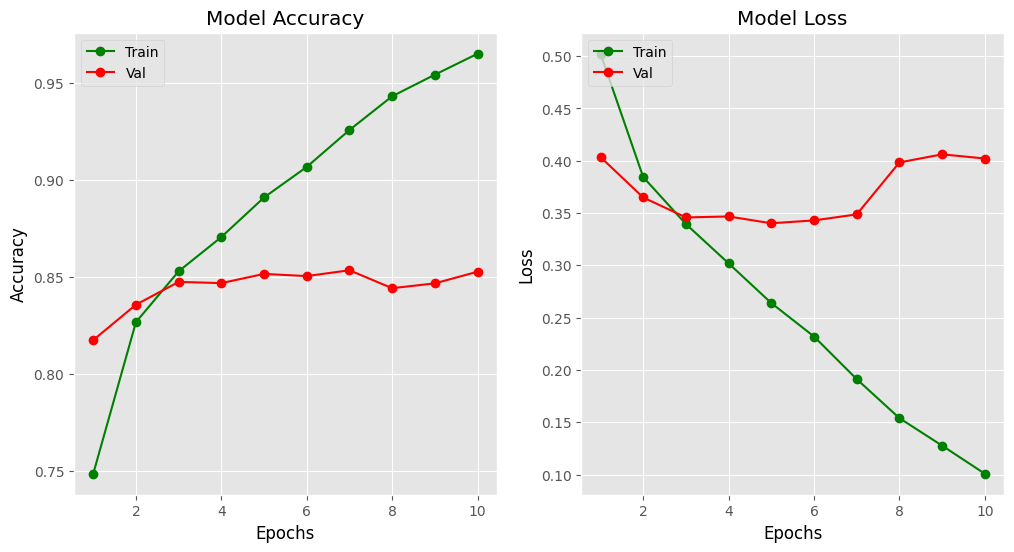

In [33]:
plt.figure(figsize=(12,6))
epochs = range(1,11)
plt.subplot(1,2,1)
plt.plot(epochs,history_cnn.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_cnn.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_cnn.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_cnn.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

> LSTM

In [34]:
lstm = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
lstm.add(embedding_layer)
lstm.add(LSTM(128)) #return_sequences=True
# lstm.add(LSTM(64, return_sequences=True))

# lstm.add(Dropout(0.2))
# lstm.add(LSTM(32))


# cnn.add(Conv1D(256,5,activation = 'relu'))
# cnn.add(GlobalMaxPooling1D())

lstm.add(Dense(1,activation = 'sigmoid'))

In [35]:
lstm.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

In [36]:
history_lstm = lstm.fit(x_train,y_train, batch_size=128, epochs = 10, 
                      verbose=1, validation_split =0.2)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.6831 - loss: 0.5823 - val_accuracy: 0.7996 - val_loss: 0.4309
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.8076 - loss: 0.4264 - val_accuracy: 0.8292 - val_loss: 0.3877
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.8280 - loss: 0.3843 - val_accuracy: 0.8487 - val_loss: 0.3540
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.8528 - loss: 0.3474 - val_accuracy: 0.8509 - val_loss: 0.3676
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 280s 1s/step - accuracy: 0.8615 - loss: 0.3270 - val_accuracy: 0.8622 - val_loss: 0.3245
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.8750 - loss: 0.3043 - val_accuracy: 0.8586 - val_loss: 0.3650
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.8789 - loss: 0.2937 - val_accuracy: 0.8666 - val_loss: 0.3306
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.8909 - loss: 0.2691 - val_accu

In [37]:
lstm_result = lstm.evaluate(x_test,y_test, verbose = 1)
print("Test Accuracy:", lstm_result[1])
print("Test Loss:", lstm_result[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 61s 194ms/step - accuracy: 0.8633 - loss: 0.3323
Test Accuracy: 0.862500011920929
Test Loss: 0.3306931257247925


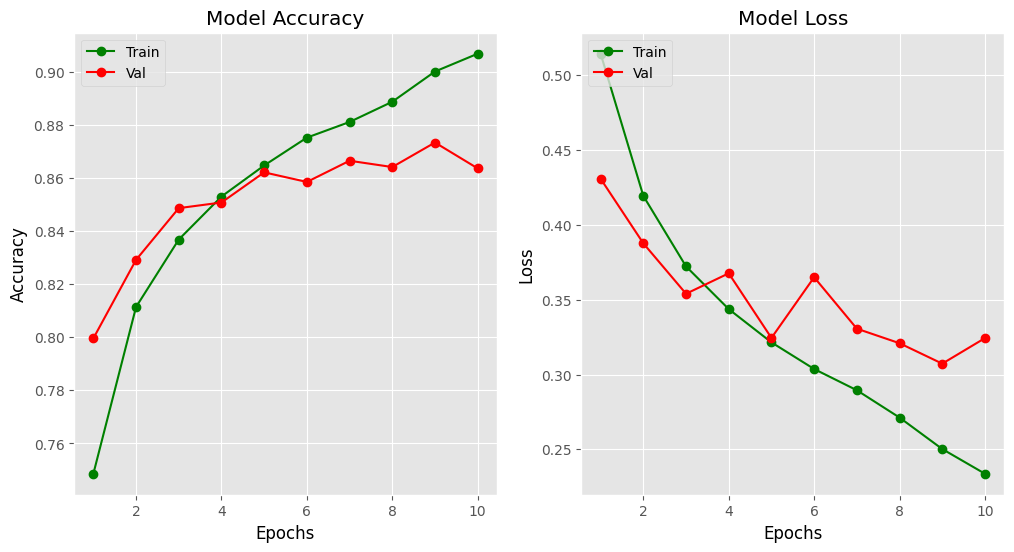

In [38]:
plt.figure(figsize=(12,6))
epochs = range(1, 11)
plt.subplot(1,2,1)
plt.plot(epochs,history_lstm.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_lstm.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_lstm.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_lstm.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

In [39]:
lstm.save("sentiment_classifier2.h5")